In [ ]:
####################################
# Contours Visualization Pipeline
####################################

In [1]:
from typing import List
import itertools
import os
import shutil
import uuid
from collections import Counter
from datetime import datetime, timedelta
from pathlib import Path
import subprocess
import tempfile
import time
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

import cv2

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError, HttpResponseError

In [2]:
SAS_TOKEN = getpass.getpass() # of the whole "cmip6" folder in Azure.
URL_PREFIX = 'https://nasanex30analysis.blob.core.windows.net/cmip6'

 ····································································································································


In [ ]:
###################################
# Utils
###################################

# class AzureSource():

#     def __init__(self, model:str, year:int):
#         fn = f"Ext_max_t__Rgn_1__{year}__Abv_Avg_5_K_for_3_days__CMIP6_{model}_Avg_yrs_1950_79.nc"
#         self.filename = fn
#         abspath = f"extremes_max/{model}/Region_1/Avg_yrs_1950_79/Abv_Avg_5_K_for_3_days/{fn}" 
#         self.abspath = abspath
            
#     def download(self):
        
#         if not os.path.isfile(self.filename):
            
# #             sas_url = f"{URL_PREFIX}/{self.abspath}?{SAS_TOKEN}"
#             sas_url = f"{URL_PREFIX}/{model}/{year}.json?{SAS_TOKEN}"
#             blob_client = BlobClient.from_blob_url(sas_url)

#             with tempfile.TemporaryFile() as f:
#                 fp = f"{f.name}.tmp"
#                 with open(fp, "wb") as my_blob:
#                     download_stream = blob_client.download_blob()
#                     my_blob.write(download_stream.readall())

#                     os.rename(fp, self.filename)
#                     while os.path.getsize(self.filename)/10**6 < 10: # MB
#                         time.sleep(2) 

# class AzureTarget():
    
#     def __init__(self, filename):
#         self.filename = filename
        
#     def upload(self, upload_folder:str):
        
#         sas_url = f"{URL_PREFIX}/{upload_folder}/{self.filename}?{SAS_TOKEN}"
#         blob_client = BlobClient.from_blob_url(sas_url)
        
#         with open(self.filename, "rb") as f:
#             if blob_client.exists():
#                 warnings.warn(f"{self.filename} exists. Overwriting..")
#             blob_client.upload_blob(f, overwrite=True)

In [35]:
###################################
# Download json files
###################################

folder = "NEWcontours_3days_5K"

models = ["GISS_E2_1_G_ssp245", "GFDL_ESM4_ssp245", "GFDL_ESM4_ssp585", "GISS_E2_1_G_ssp585"]
years = list(range(2020,2030))

for model in models:
    
    for year in years:
        
        fp = f"{model}_{year}.json"
        sas_url = f"{URL_PREFIX}/{folder}/{model}/{fp}?{SAS_TOKEN}"
        blob_client = BlobClient.from_blob_url(sas_url)

        if not os.path.exists(model):
            os.mkdir(model)
                
        with open(f"{model}/{fp}", "wb") as my_blob:
            download_stream = blob_client.download_blob()
            my_blob.write(download_stream.readall())


In [72]:
###################################
# Read all meta data into single df
###################################

dfs = []
for model in models:
    jsons = sorted([str(p) for p in Path(model).rglob("*.json")])
    df = pd.concat([pd.read_json(j) for j in jsons], axis=0)
    df['model'] = model
    dfs.append(df)
    
df_meta = pd.concat(dfs, axis=0).reset_index(drop=True)


In [102]:

df = df_meta[df_meta['type']=='daily'].groupby(['model','days']).agg({'area':['count','sum']})
df = df.reset_index()
df.columns = ['model','day','contour_count','total_area']
df['day'] = df['day'].astype('datetime64[ns]')
df

,model,day,contour_count,total_area
0,GFDL_ESM4_ssp245,2020-01-01,4,2218.0
1,GFDL_ESM4_ssp245,2020-01-02,4,4570.5
2,GFDL_ESM4_ssp245,2020-01-03,5,6622.5
3,GFDL_ESM4_ssp245,2020-01-04,7,9515.5
4,GFDL_ESM4_ssp245,2020-01-05,4,14353.0
...,...,...,...,...
14595,GISS_E2_1_G_ssp585,2029-12-27,6,17137.5
14596,GISS_E2_1_G_ssp585,2029-12-28,4,21065.5
14597,GISS_E2_1_G_ssp585,2029-12-29,6,21033.0
14598,GISS_E2_1_G_ssp585,2029-12-30,8,19060.5


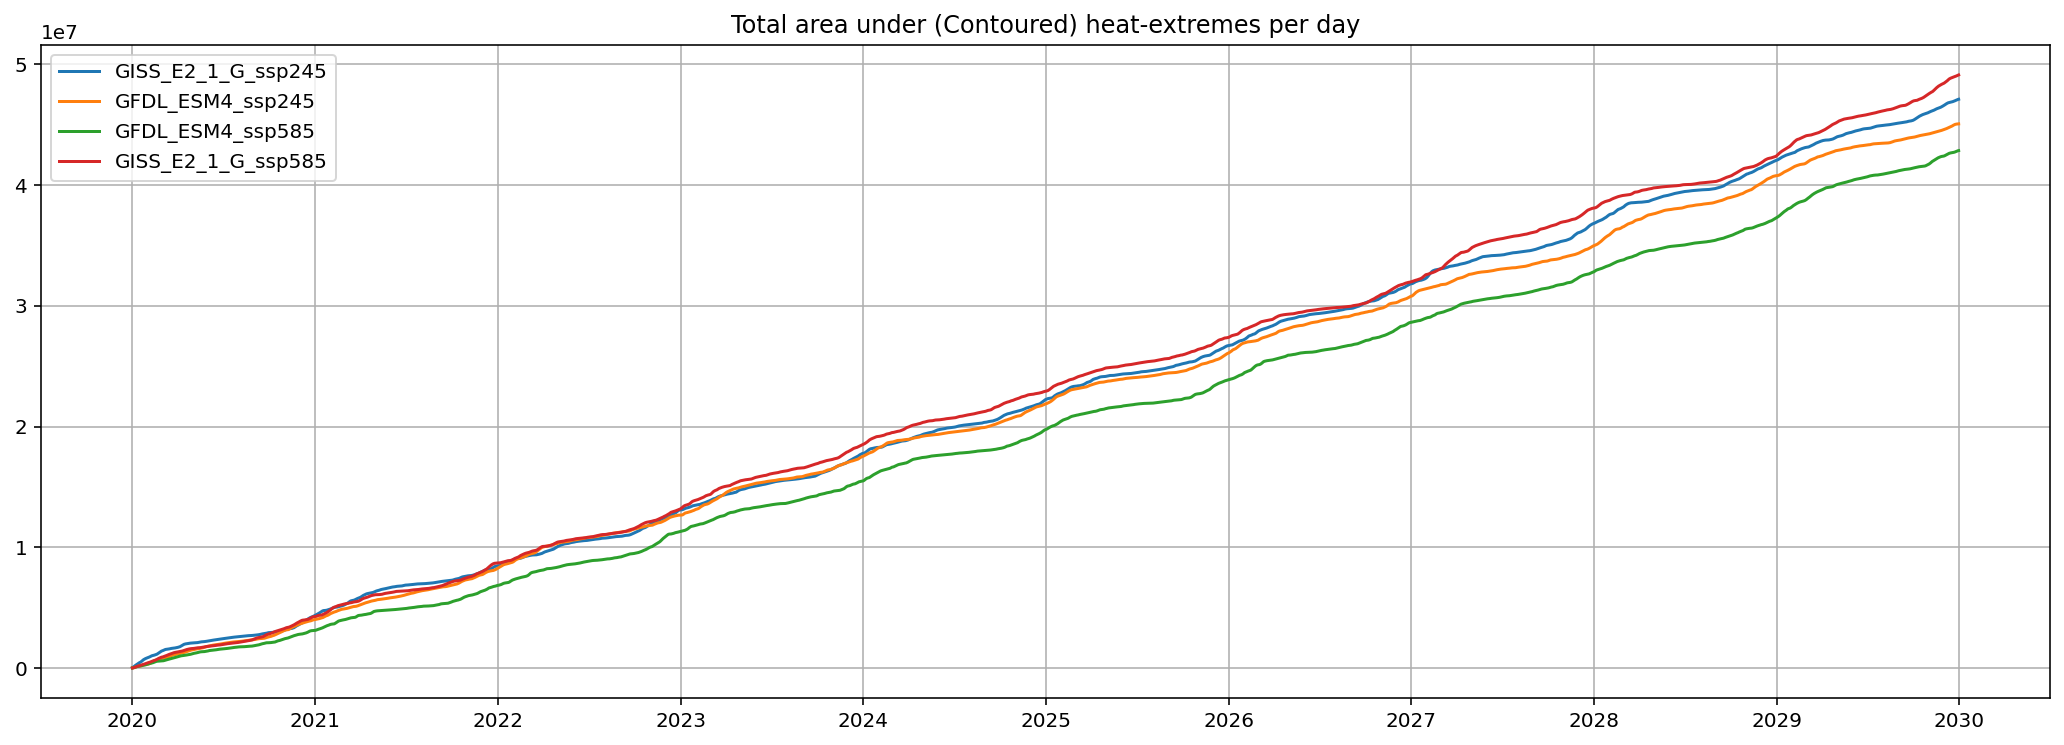

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(18,6))


for model in models:
    
    y = df[df['model']==model]['total_area'].cumsum()
    x = df[df['model']==model]['day']
    ax.plot(x, y, label=model);

ax.set_title("Total area under (Contoured) heat-extremes per day")
ax.grid()
ax.legend();